In [1]:
import os
import glob

import mne
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
sfreq = 100
n_jobs = 30

In [3]:
files = glob.glob('/home/jovyan/competition/data/**/*_raw.fif.gz')

In [4]:
def do(file, sfreq):
    raw = mne.io.read_raw_fif(file, verbose='error')
    raw.resample(sfreq=sfreq)
    file = file.replace('_raw.fif.gz', f'_{sfreq}_hz_raw.fif.gz')
    raw.save(file)

    means = raw.get_data(units='uV').mean(axis=1)
    stds = raw.get_data(units='uV').std(axis=1)
    chs = raw.ch_names
    df = pd.DataFrame({'mean': means, 'std': stds}, index=chs)
    ext = files[0][files[0].find('.'):]
    df.to_csv(file.replace(ext, '_stats.csv'))

In [5]:
_ = Parallel(n_jobs=n_jobs)(delayed(do)(file, sfreq) for file in files)

Writing /home/jovyan/competition/data/testing/subj1393_EO_100_hz_raw.fif.gz
Closing /home/jovyan/competition/data/testing/subj1393_EO_100_hz_raw.fif.gz
[done]
Writing /home/jovyan/competition/data/testing/subj1555_EO_100_hz_raw.fif.gz
Writing /home/jovyan/competition/data/testing/subj1477_EO_100_hz_raw.fif.gz
Closing /home/jovyan/competition/data/testing/subj1555_EO_100_hz_raw.fif.gz
Closing /home/jovyan/competition/data/testing/subj1477_EO_100_hz_raw.fif.gz
[done]
[done]
Writing /home/jovyan/competition/data/testing/subj1541_EO_100_hz_raw.fif.gz
Closing /home/jovyan/competition/data/testing/subj1541_EO_100_hz_raw.fif.gz
[done]
Writing /home/jovyan/competition/data/testing/subj1212_EO_100_hz_raw.fif.gz
Writing /home/jovyan/competition/data/testing/subj1206_EO_100_hz_raw.fif.gz
Writing /home/jovyan/competition/data/testing/subj1273_EO_100_hz_raw.fif.gz
Closing /home/jovyan/competition/data/testing/subj1212_EO_100_hz_raw.fif.gz
[done]
Writing /home/jovyan/competition/data/testing/subj152

In [6]:
print("hi")

hi


In [15]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [23]:
# download data https://filesender.renater.fr/?s=download&token=e1de0ec4-09bc-4194-b85b-59830cb04af3
# download test data from https://codalab.lisn.upsaclay.fr/competitions/8336

# Path to training data
train_path = "/home/jovyan/competition/data/training/"
# Path to testing data (public test set)
test_path = "/home/jovyan/competition/data/testing/"
train_subj = 1200  # use 10 instead of 1200 training subjects, for demonstration purpose
test_subj = 400  # use 10 instead of 400 testing subjects, for demonstration purpose

train_raws, test_raws = {}, {}
for condition in ["EC", "EO"]:
    train_raws[condition] = []
    test_raws[condition] = []
    train_subjs = list(range(1, train_subj + 1))
    for s in train_subjs:
        fname = f"subj{s:04}_{condition}_{sfreq}_hz_raw.fif.gz"
        raw = mne.io.read_raw(train_path + fname, preload=False, verbose='error')
        train_raws[condition].append(raw)
    test_subjs = list(range(1201, 1201 + test_subj))
    for s in test_subjs:
        fname = f"subj{s:04}_{condition}_{sfreq}_hz_raw.fif.gz"
        raw = mne.io.read_raw(test_path + fname, preload=False, verbose='error')
        test_raws[condition].append(raw)

In [24]:
meta = pd.read_csv(train_path + "train_subjects.csv", index_col=0)
meta = pd.concat([meta, meta])
meta['condition'] = len(train_raws['EC']) * ['EC'] + len(train_raws['EO']) * ['EO']
train_raws = train_raws['EC'] + train_raws['EO']
len(train_raws), len(meta)

(2400, 2400)

In [12]:
test_meta = pd.DataFrame({'condition': len(test_raws['EC']) * ['EC'] + len(test_raws['EO']) * ['EO']})
test_raws = test_raws['EC'] + test_raws['EO']
len(test_raws), len(test_meta)

(800, 800)

In [16]:
from braindecode.datasets import BaseConcatDataset, BaseDataset

In [26]:
target_name = 'age'

In [27]:
train = BaseConcatDataset([
    BaseDataset(raw, target_name=target_name) for raw in train_raws
])
meta['subject'] = meta['id']
train.set_description(meta)
train.set_description({'path': [ds.raw.filenames[0] for ds in train.datasets]})

/home/jovyan/braindecode/braindecode/datasets/base.py:131: UserWarning: 'age' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [21]:
import pickle

In [29]:
with open(train_path + f'train_{sfreq}_hz.pkl', 'wb') as f:
    pickle.dump(train, f)

In [17]:
test = BaseConcatDataset([
    BaseDataset(raw) for raw in test_raws
])
test_meta['subject'] = test_subjs + test_subjs
test.set_description(test_meta)
test.set_description({'path': [ds.raw.filenames[0] for ds in test.datasets]})

In [22]:
with open(test_path + f'test_{sfreq}_hz.pkl', 'wb') as f:
    pickle.dump(test, f)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

ValueError: Could not interpret value `age` for parameter `y`

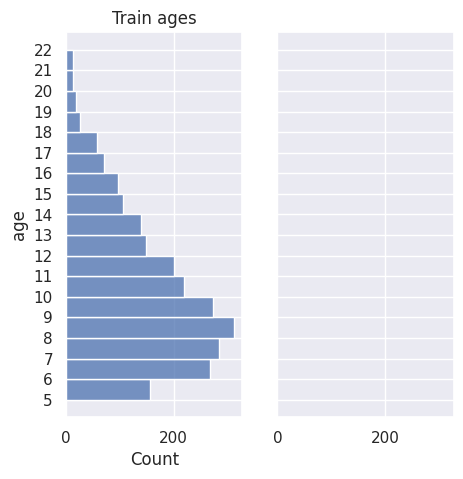

In [31]:
fig, ax_arr = plt.subplots(1, 2, figsize=(5,5), sharex=True, sharey=True)
bins = bins=range(5, 23)
ax = ax_arr[0]
ax = sns.histplot(data=train.description, y='age', bins=bins, ax=ax)
ax.set_yticks(bins);
ax.set_yticklabels(bins);
ax.set_title('Train ages')

ax = ax_arr[1]
ax = sns.histplot(data=test.description, y='age', bins=bins, ax=ax)
ax.set_title('Valid ages')